In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd

style.use('default')
import matplotlib.path as mpath

In [4]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['x_graze_zoo1_zint','x_graze_zoo2_zint',
            'x_graze_zoo3_zint','x_graze_zoo4_zint','photoC_TOT_zint','photoC_diat_zint']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','time_bound','TAREA','REGION_MASK', 'time'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

#### get case

In [5]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004
x_graze_zoo1_zint
x_graze_zoo2_zint
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_TOT_zint
photoC_diat_zint
CPU times: user 3.29 s, sys: 1.02 s, total: 4.31 s
Wall time: 9.02 s


In [4]:
### snip off the first two years, as these are still adjusting from initialization
ds = ds.isel(time=slice(2,61))

## calculate z-ratio
ds['zratio'] = ds.x_graze_zoo3_zint /ds.photoC_TOT_zint

ds['z2ratio'] = (ds.x_graze_zoo3_zint + ds.x_graze_zoo4_zint) /ds.photoC_TOT_zint

#make NPP and zooplankton production terms in an useful unit
# mmol/m3 cm/s -----> mmol/m2/d

ds['NPP'] = ds.photoC_TOT_zint * 0.01 * 86400.
ds['x_graze_zoo1_zint'] = ds.x_graze_zoo1_zint * 0.01 * 86400.
ds['x_graze_zoo2_zint'] = ds.x_graze_zoo2_zint * 0.01 * 86400.
ds['x_graze_zoo3_zint'] = ds.x_graze_zoo3_zint * 0.01 * 86400.
ds['x_graze_zoo4_zint'] = ds.x_graze_zoo4_zint * 0.01 * 86400.

ds['sm_zoo_prod'] = ds.x_graze_zoo1_zint + ds.x_graze_zoo2_zint
ds['lg_zoo_prod'] = ds.x_graze_zoo3_zint + ds.x_graze_zoo4_zint

ds['zoo_TOT_prod'] = ds.x_graze_zoo3_zint + ds.x_graze_zoo4_zint + ds.x_graze_zoo3_zint + ds.x_graze_zoo4_zint

In [5]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1.e-4
depths=ds_grid.z_t * 0.01
tlen=len(ds.time)
years = np.arange(1960,1960+tlen,1)
years

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

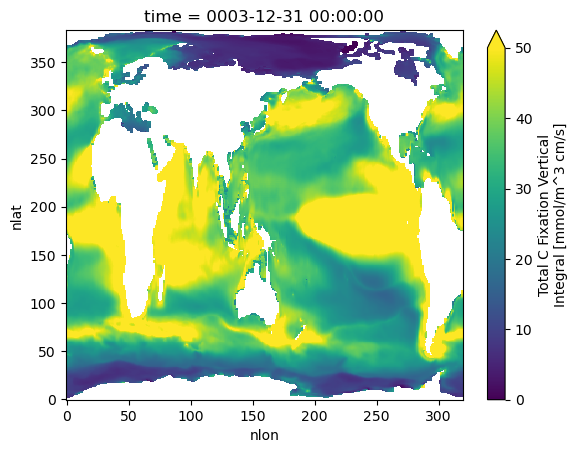

In [6]:
ds['NPP'].isel(time=0).plot(vmin=0,vmax=50)

In [7]:
ds.photoC_TOT_zint

<xarray.DataArray 'photoC_TOT_zint' (time: 59, nlat: 384, nlon: 320)>
dask.array<getitem, shape=(59, 384, 320), dtype=float32, chunksize=(59, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0003-12-31 00:00:00 ... 0061-12-31 00:00:00
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Total C Fixation Vertical Integral
    units:         mmol/m^3 cm/s
    grid_loc:      2110
    cell_methods:  time: mean

### Get SAM indices

In [8]:
csv_file = '/glade/work/kristenk/SAM_index/SAM_indices.csv'
sam_indices = pd.read_csv(csv_file, header=None)
sam_indices.columns = ['year', 'ANN', 'AUT' , 'WIN', 'SPR', 'SUM']
sam_indices

year   ANN   AUT   WIN   SPR   SUM
0   1957 -4.24 -2.52 -0.68 -3.55 -2.52
1   1958 -1.27 -2.97 -0.92  1.42  1.12
2   1959  0.47 -0.94 -1.22  3.20  0.31
3   1960  1.52  0.74  0.32  1.00 -0.08
4   1961  1.22  0.48  0.93  0.85  2.19
..   ...   ...   ...   ...   ...   ...
58  2015  4.13  1.43  3.19  1.75  2.19
59  2016  1.67  1.64  1.49 -0.31 -1.75
60  2017  1.67  1.34  1.15  1.42  2.33
61  2018  1.96 -0.81 -0.76  3.92  1.43
62  2019 -1.50  1.03 -1.30 -2.57 -0.96

[63 rows x 6 columns]

### plotting function (helps with South Pole stereographic map)

In [9]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### do mean, st dev, and mean/stdev calculations

In [10]:
st_dev_zratio = ds.zratio.std(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
mean_zratio = ds.zratio.mean(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_zratio = st_dev_zratio/mean_zratio

st_dev_z2ratio = ds.z2ratio.std(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
mean_z2ratio = ds.z2ratio.mean(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_z2ratio = st_dev_z2ratio/mean_z2ratio

st_dev_NPP = ds.NPP.std(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
mean_NPP= ds.NPP.mean(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_NPP = st_dev_NPP/mean_NPP

st_dev_zoo1 = ds.x_graze_zoo1_zint.std(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
mean_zoo1= ds.x_graze_zoo1_zint.mean(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_zoo1 = st_dev_zoo1/mean_zoo1

st_dev_zoo2 = ds.x_graze_zoo2_zint.std(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
mean_zoo2= ds.x_graze_zoo2_zint.mean(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_zoo2 = st_dev_zoo2/mean_zoo2

st_dev_zoo3 = ds.x_graze_zoo3_zint.std(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
mean_zoo3= ds.x_graze_zoo3_zint.mean(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_zoo3 = st_dev_zoo3/mean_zoo3

st_dev_zoo4 = ds.x_graze_zoo4_zint.std(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
mean_zoo4= ds.x_graze_zoo4_zint.mean(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_zoo4 = st_dev_zoo4/mean_zoo4

st_dev_smzoo = ds.sm_zoo_prod.std(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
mean_smzoo= ds.sm_zoo_prod.mean(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_smzoo = st_dev_smzoo/mean_smzoo

st_dev_lgzoo = ds.lg_zoo_prod.std(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
mean_lgzoo= ds.lg_zoo_prod.mean(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_lgzoo = st_dev_lgzoo/mean_lgzoo

st_dev_zoo = ds.zoo_TOT_prod.std(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
mean_zoo= ds.zoo_TOT_prod.mean(dim='time') #.where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_zoo = st_dev_zoo/mean_zoo

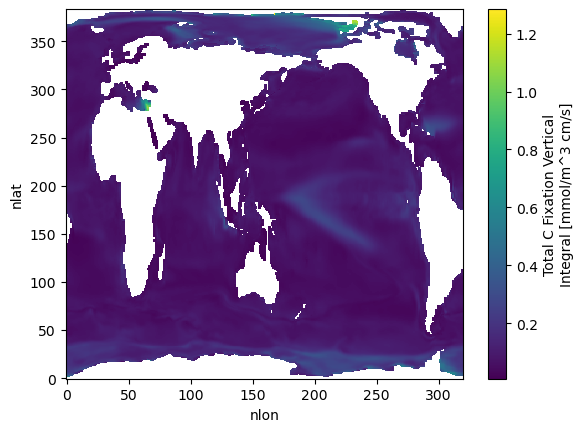

In [11]:
norm_stdev_NPP.plot()

### Do SAM annual correlations

In [12]:
# ds_sam = xr.Dataset()
# ds_sam['time'] = sam_indices.year.values

# na = np.newaxis
# da_sam = sam_indices.ANN.values[:,na,na]
# da_sam = xr.DataArray(da_sam, dims=('time','lat','lon'))
# ds_sam['ANN'] = da_sam

# na = np.newaxis
# da_sam = sam_indices.SUM.values[:,na,na]
# da_sam = xr.DataArray(da_sam, dims=('time','lat','lon'))
# ds_sam['SUM'] = da_sam

# na = np.newaxis
# da_sam = sam_indices.WIN.values[:,na,na]
# da_sam = xr.DataArray(da_sam, dims=('time','lat','lon'))
# ds_sam['WIN'] = da_sam

# #trim to time period of JRA forcing
# ds_sam = ds_sam.isel(time=slice(1,62))

In [13]:
time_sam = sam_indices.year.values
da_time_sam = xr.DataArray(time_sam, dims=('time'))
da_time_sam = da_time_sam.isel(time=slice(3,62))
da_time_sam.values

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

In [16]:
ann_sam = sam_indices.ANN.values
na = np.newaxis
da_sam = ann_sam[:,na,na]
da_sam = xr.DataArray(da_sam, dims=('time','lat','lon'))

#just get the overlapping timeperiod with the model
da_sam = da_sam.isel(time=slice(3,62))

In [17]:
NPP_sam_ann_corr = xr.corr(ds.NPP, da_sam, dim='time')
NPP_sam_ann_corr = NPP_sam_ann_corr.squeeze()

zratio_sam_ann_corr = xr.corr(ds.zratio, da_sam, dim='time')
zratio_sam_ann_corr = zratio_sam_ann_corr.squeeze()

z2ratio_sam_ann_corr = xr.corr(ds.z2ratio, da_sam, dim='time')
z2ratio_sam_ann_corr = z2ratio_sam_ann_corr.squeeze()

zoo1_sam_ann_corr = xr.corr(ds.x_graze_zoo1_zint, da_sam, dim='time')
zoo1_sam_ann_corr = zoo1_sam_ann_corr.squeeze()

zoo2_sam_ann_corr = xr.corr(ds.x_graze_zoo2_zint, da_sam, dim='time')
zoo2_sam_ann_corr = zoo2_sam_ann_corr.squeeze()

zoo3_sam_ann_corr = xr.corr(ds.x_graze_zoo3_zint, da_sam, dim='time')
zoo3_sam_ann_corr = zoo3_sam_ann_corr.squeeze()

zoo4_sam_ann_corr = xr.corr(ds.x_graze_zoo4_zint, da_sam, dim='time')
zoo4_sam_ann_corr = zoo4_sam_ann_corr.squeeze()

### Do SAM summer correlations

In [18]:
sum_sam = sam_indices.SUM.values
na = np.newaxis
da_sam_sum = sum_sam[:,na,na]
da_sam_sum = xr.DataArray(da_sam_sum, dims=('time','lat','lon'))

#just get the overlapping timeperiod with the model
da_sam_sum = da_sam_sum.isel(time=slice(3,62))

In [19]:
NPP_sam_sum_corr = xr.corr(ds.NPP, da_sam_sum, dim='time')
NPP_sam_sum_corr = NPP_sam_sum_corr.squeeze()

zratio_sam_sum_corr = xr.corr(ds.zratio, da_sam_sum, dim='time')
zratio_sam_sum_corr = zratio_sam_sum_corr.squeeze()

z2ratio_sam_sum_corr = xr.corr(ds.z2ratio, da_sam_sum, dim='time')
z2ratio_sam_sum_corr = z2ratio_sam_sum_corr.squeeze()

zoo1_sam_sum_corr = xr.corr(ds.x_graze_zoo1_zint, da_sam_sum, dim='time')
zoo1_sam_sum_corr = zoo1_sam_sum_corr.squeeze()

zoo2_sam_sum_corr = xr.corr(ds.x_graze_zoo2_zint, da_sam_sum, dim='time')
zoo2_sam_sum_corr = zoo2_sam_sum_corr.squeeze()

zoo3_sam_sum_corr = xr.corr(ds.x_graze_zoo3_zint, da_sam_sum, dim='time')
zoo3_sam_sum_corr = zoo3_sam_sum_corr.squeeze()

zoo4_sam_sum_corr = xr.corr(ds.x_graze_zoo4_zint, da_sam_sum, dim='time')
zoo4_sam_sum_corr = zoo4_sam_sum_corr.squeeze()

### Do SAM winter correlations

In [23]:
win_sam = sam_indices.WIN.values
na = np.newaxis
da_sam_win = win_sam[:,na,na]
da_sam_win = xr.DataArray(da_sam_win, dims=('time','lat','lon'))

#just get the overlapping timeperiod with the model
da_sam_win = da_sam_win.isel(time=slice(3,62))

In [24]:
NPP_sam_win_corr = xr.corr(ds.NPP, da_sam_win, dim='time')
NPP_sam_win_corr = NPP_sam_win_corr.squeeze()

zratio_sam_win_corr = xr.corr(ds.zratio, da_sam_win, dim='time')
zratio_sam_win_corr = zratio_sam_win_corr.squeeze()

z2ratio_sam_win_corr = xr.corr(ds.z2ratio, da_sam_win, dim='time')
z2ratio_sam_win_corr = z2ratio_sam_win_corr.squeeze()

zoo1_sam_win_corr = xr.corr(ds.x_graze_zoo1_zint, da_sam_win, dim='time')
zoo1_sam_win_corr = zoo1_sam_win_corr.squeeze()

zoo2_sam_win_corr = xr.corr(ds.x_graze_zoo2_zint, da_sam_win, dim='time')
zoo2_sam_win_corr = zoo2_sam_win_corr.squeeze()

zoo3_sam_win_corr = xr.corr(ds.x_graze_zoo3_zint, da_sam_win, dim='time')
zoo3_sam_win_corr = zoo3_sam_win_corr.squeeze()

zoo4_sam_win_corr = xr.corr(ds.x_graze_zoo4_zint, da_sam_win, dim='time')
zoo4_sam_win_corr = zoo4_sam_win_corr.squeeze()

### NPP plots

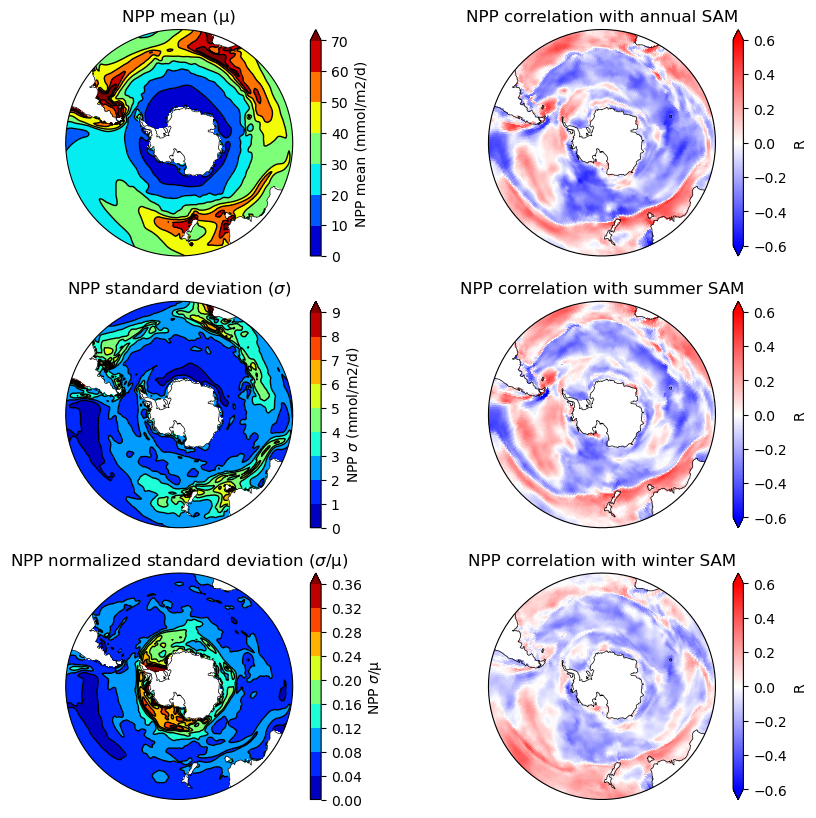

In [25]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_NPP)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,80,10)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP mean (µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='NPP mean (mmol/m2/d)')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_NPP)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,10,1)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='NPP ${\sigma}$ (mmol/m2/d)')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_NPP)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.4,0.04)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP normalized standard deviation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='NPP ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, NPP_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, NPP_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, NPP_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### z-ratio (zoo3 prod/NPP) plots

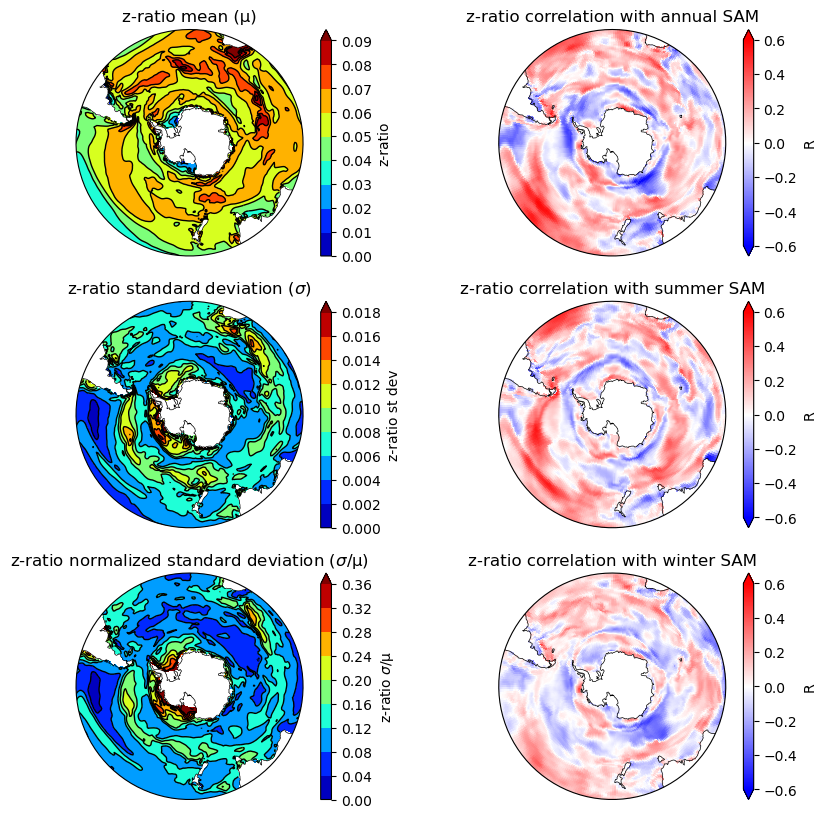

In [26]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_zratio)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.1,0.01)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('z-ratio mean (µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='z-ratio')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_zratio)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.02,0.002)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('z-ratio standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='z-ratio st dev')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_zratio)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.4,0.04)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('z-ratio normalized standard deviation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='z-ratio ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zratio_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('z-ratio correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zratio_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('z-ratio correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zratio_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('z-ratio correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### z2-ratio = (zoo3 prod + zoo4 prod)/NPP

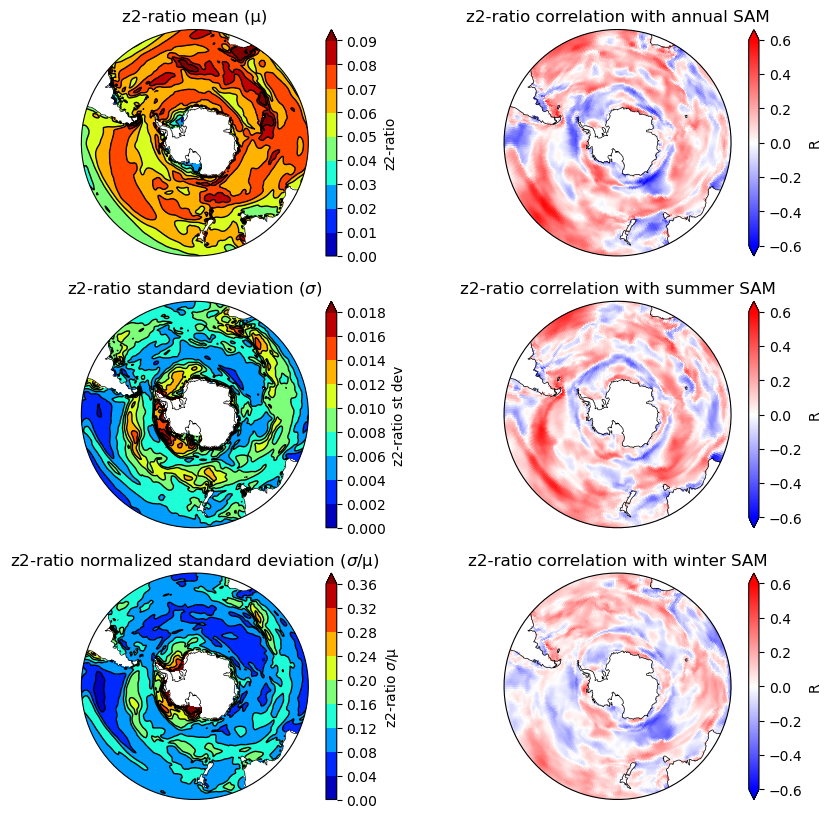

In [27]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_z2ratio)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.1,0.01)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('z2-ratio mean (µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='z2-ratio')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_z2ratio)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.02,0.002)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('z2-ratio standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='z2-ratio st dev')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_z2ratio)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.4,0.04)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('z2-ratio normalized standard deviation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='z2-ratio ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, z2ratio_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('z2-ratio correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, z2ratio_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('z2-ratio correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, z2ratio_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('z2-ratio correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

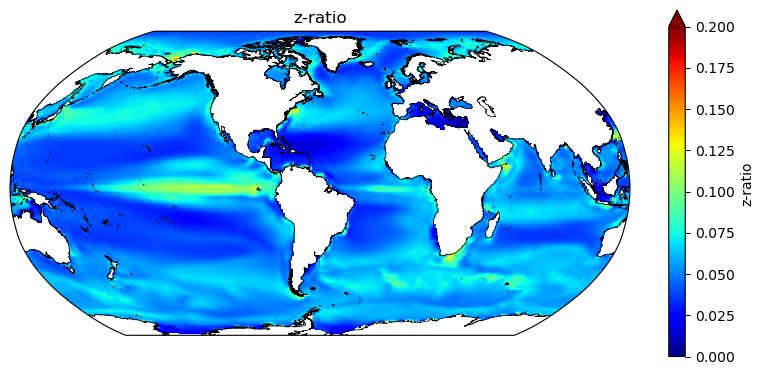

In [28]:
lon, lat, field = adjust_pop_grid(lons, lats, mean_zratio)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='z-ratio')

Roman et al. (2002) showed that BATS z-ratio is ~ 0.02 and HOT z-ratio is 0.05

### Look at production of each zooplankton group

## zoo1

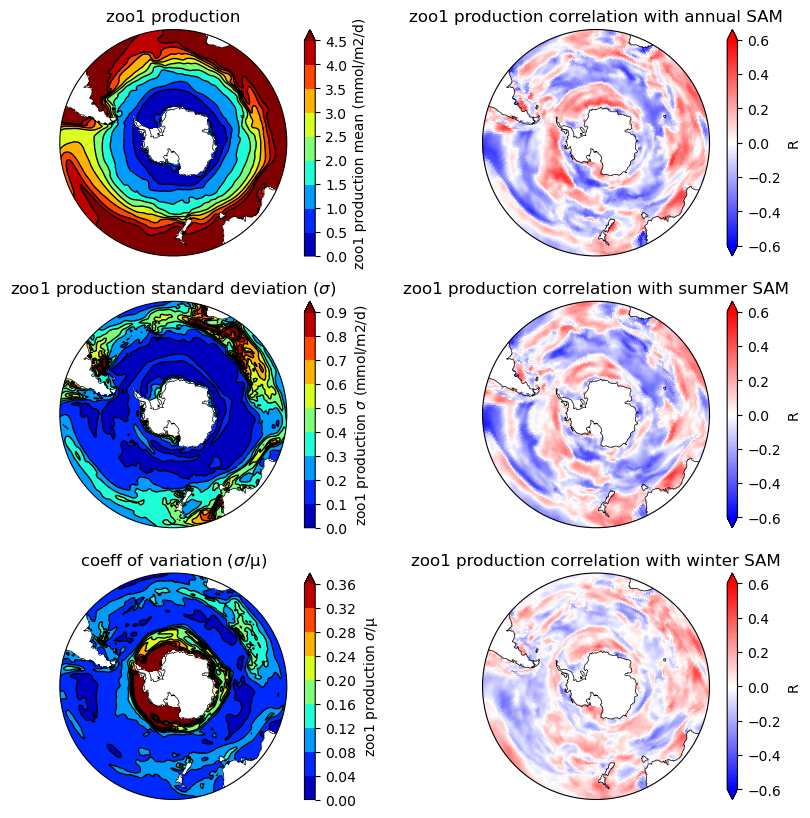

In [29]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_zoo1)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,5,0.5)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1 production')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo1 production mean (mmol/m2/d)')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_zoo1)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,1,0.1)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1 production standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo1 production ${\sigma}$ (mmol/m2/d)')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_zoo1)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.4,0.04)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('coeff of variation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo1 production ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo1_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1 production correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo1_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1 production correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo1_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1 production correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### zoo2

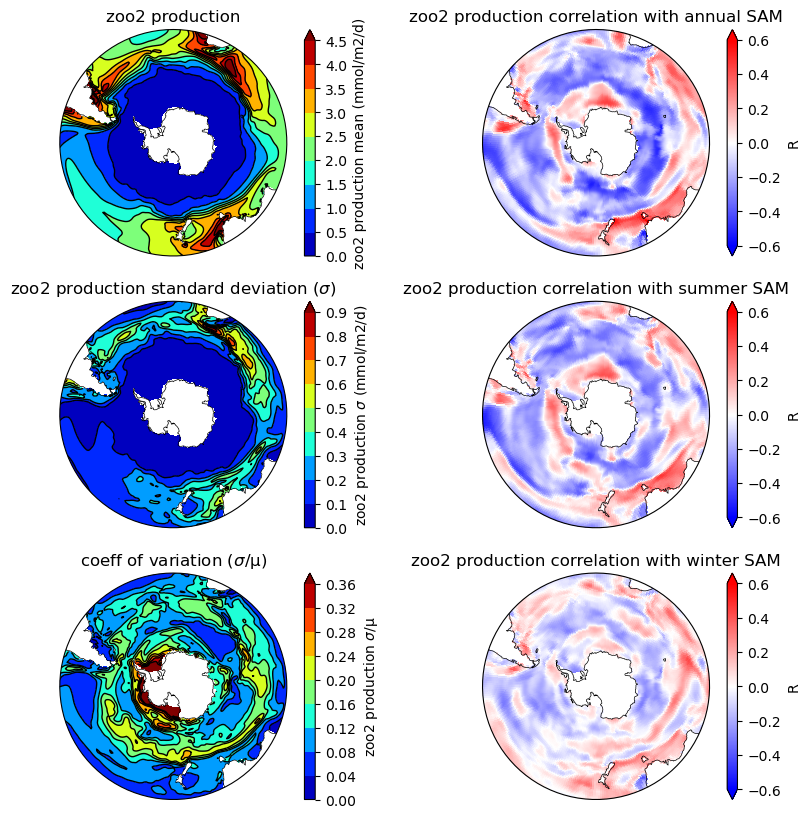

In [30]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_zoo2)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,5,0.5)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo2 production')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo2 production mean (mmol/m2/d)')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_zoo2)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,1,0.1)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo2 production standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo2 production ${\sigma}$ (mmol/m2/d)')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_zoo2)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.4,0.04)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('coeff of variation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo2 production ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo2_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo2 production correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo2_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo2 production correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo2_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo2 production correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

## zoo3

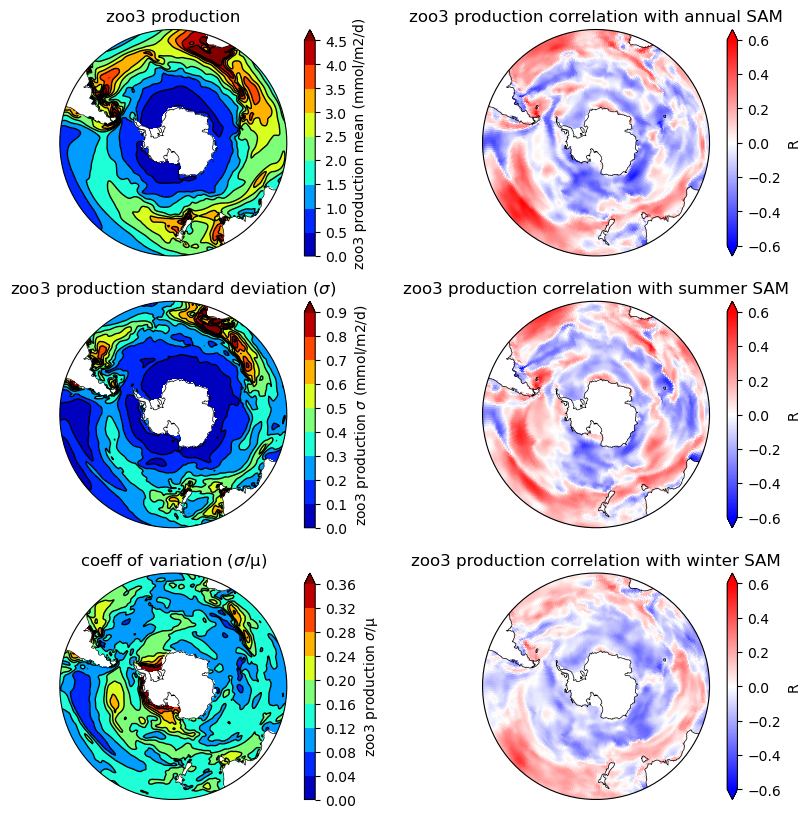

In [31]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_zoo3)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,5,0.5)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 production')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo3 production mean (mmol/m2/d)')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_zoo3)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,1,0.1)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 production standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo3 production ${\sigma}$ (mmol/m2/d)')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_zoo3)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.4,0.04)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('coeff of variation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo3 production ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 production correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 production correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 production correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

## zoo4

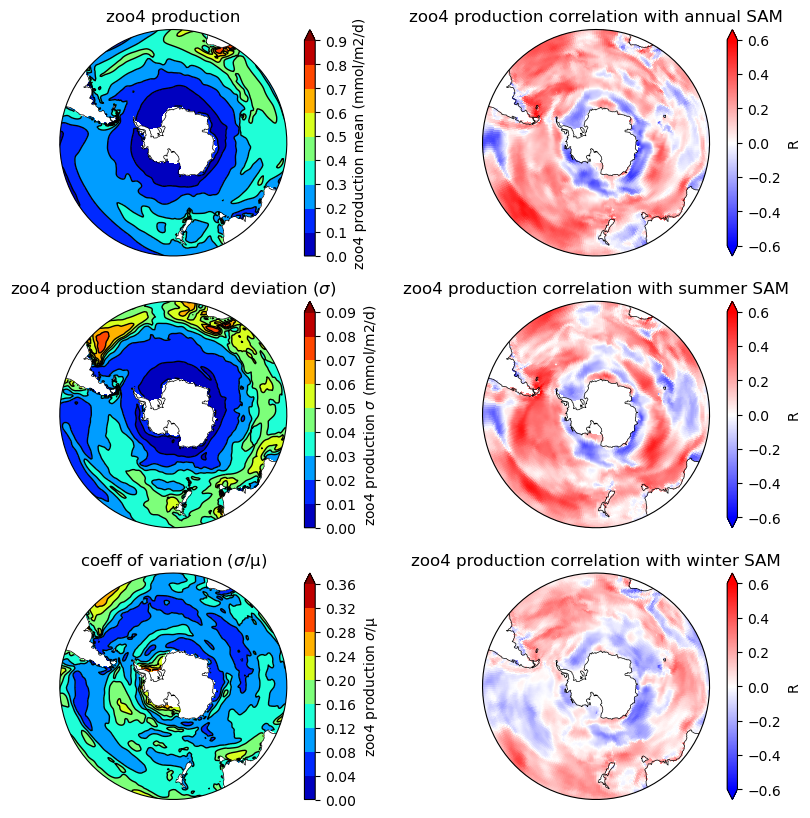

In [32]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_zoo4)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,1,0.1)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4 production')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo4 production mean (mmol/m2/d)')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_zoo4)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.1,0.01)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4 production standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo4 production ${\sigma}$ (mmol/m2/d)')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_zoo4)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.4,0.04)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('coeff of variation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo4 production ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4 production correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4 production correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4 production correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

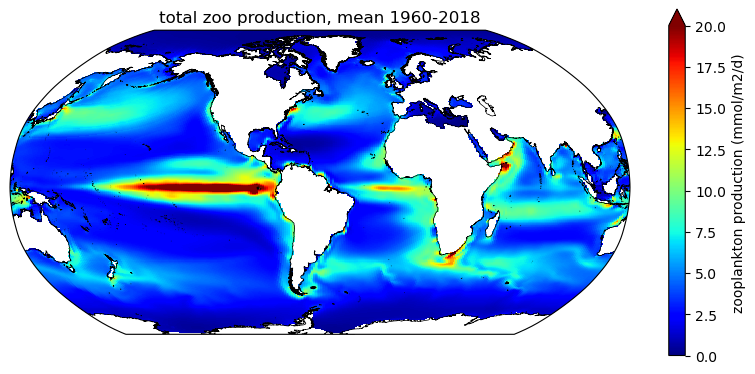

In [36]:
fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, mean_zoo)

ax.set_title('total zoo production, mean 1960-2018', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=20,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooplankton production (mmol/m2/d)')